# Query the PACBED CNN service using Python

In [1]:
%matplotlib nbagg

In [2]:
import matplotlib.pyplot as plt
from ncempy.io import dm
from pacbedclient import query

## Load and display example image

In [3]:
pacbed = dm.dmReader("../../tests/pacbed_files/rutile_80kV_1.dm4")

<IPython.core.display.Javascript object>


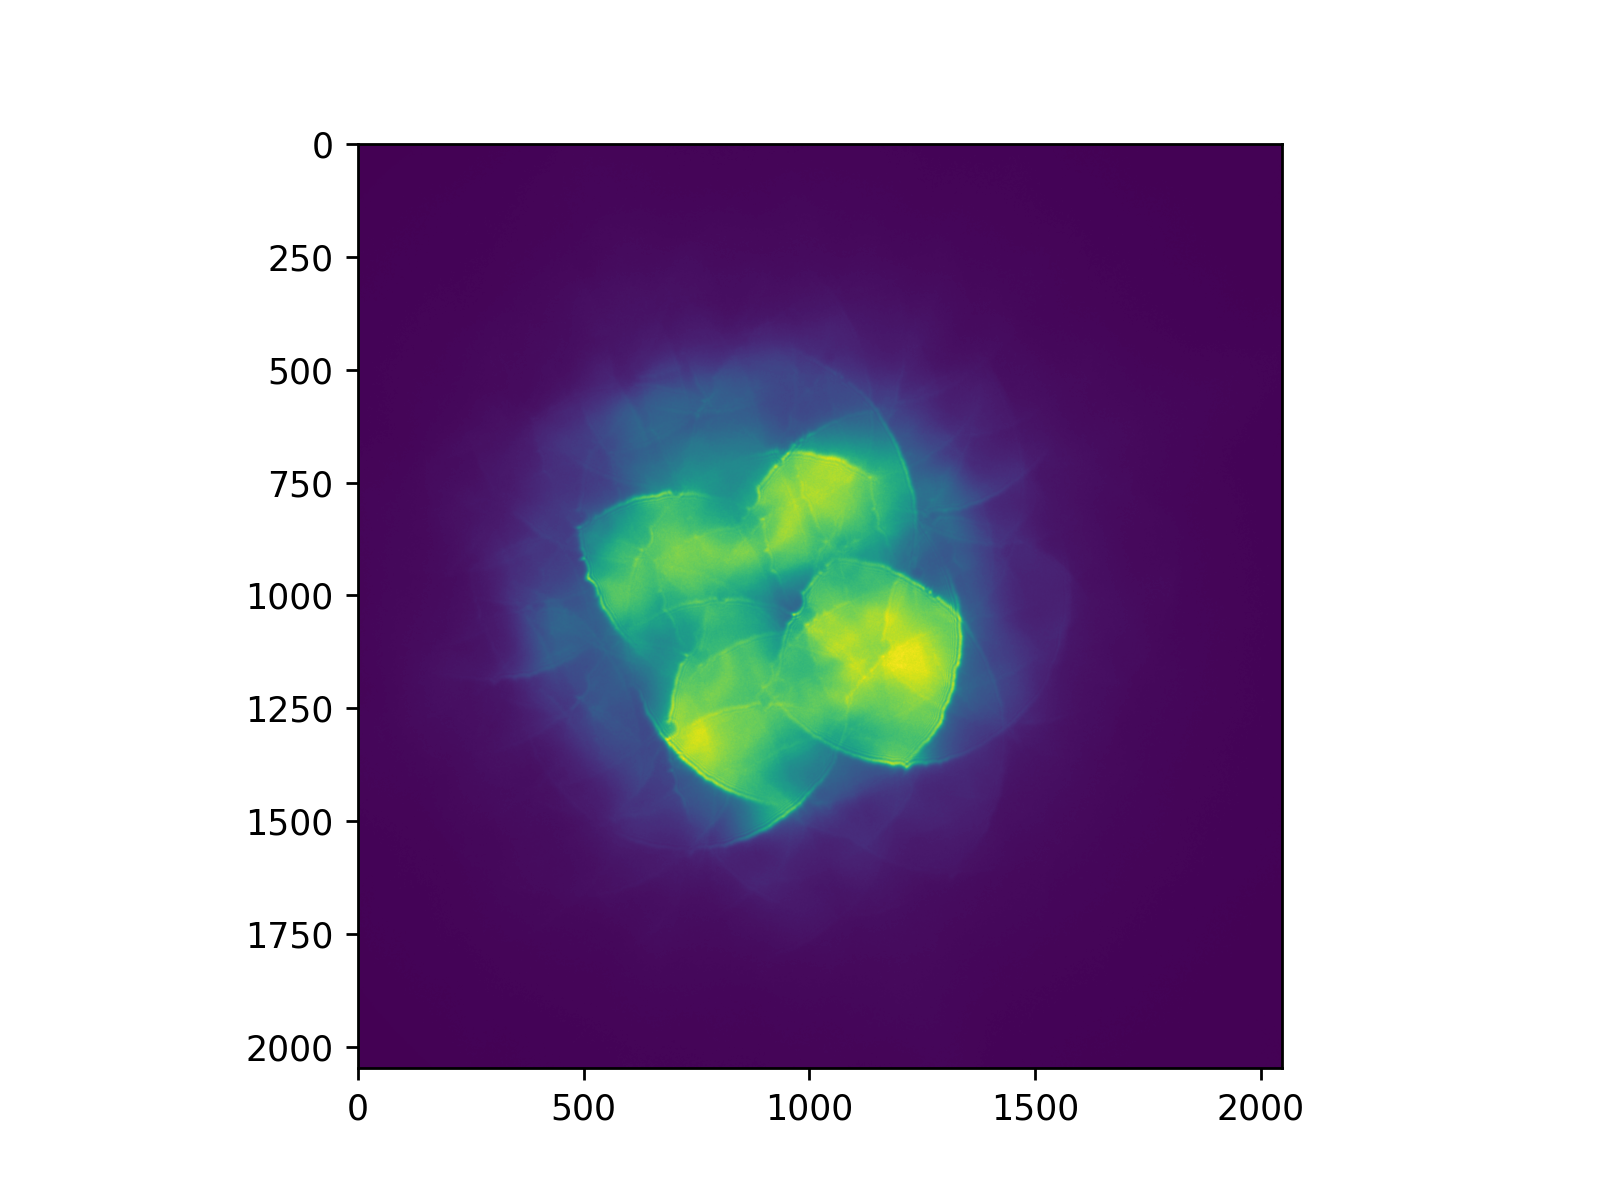

In [4]:
fig, ax = plt.subplots(1)
ax.imshow(pacbed['data'])

## Query and display result

In [5]:
%%time
result = query(
    image_array=pacbed['data'],
    crystal_structure='Rutile',
    acceleration_voltage=80000,
    convergence_angle=20,
    zone_u=0, zone_v=0, zone_w=1,
    host='localhost',
    port='8230'
)

CPU times: user 45.7 ms, sys: 27 ms, total: 72.7 ms
Wall time: 2.41 s


In [6]:
result

{'thickness': 170.0,
 'mistilt': 4.0,
 'scale': 0.8621834643701758,
 'validation': array([[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        ...,
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]

<IPython.core.display.Javascript object>


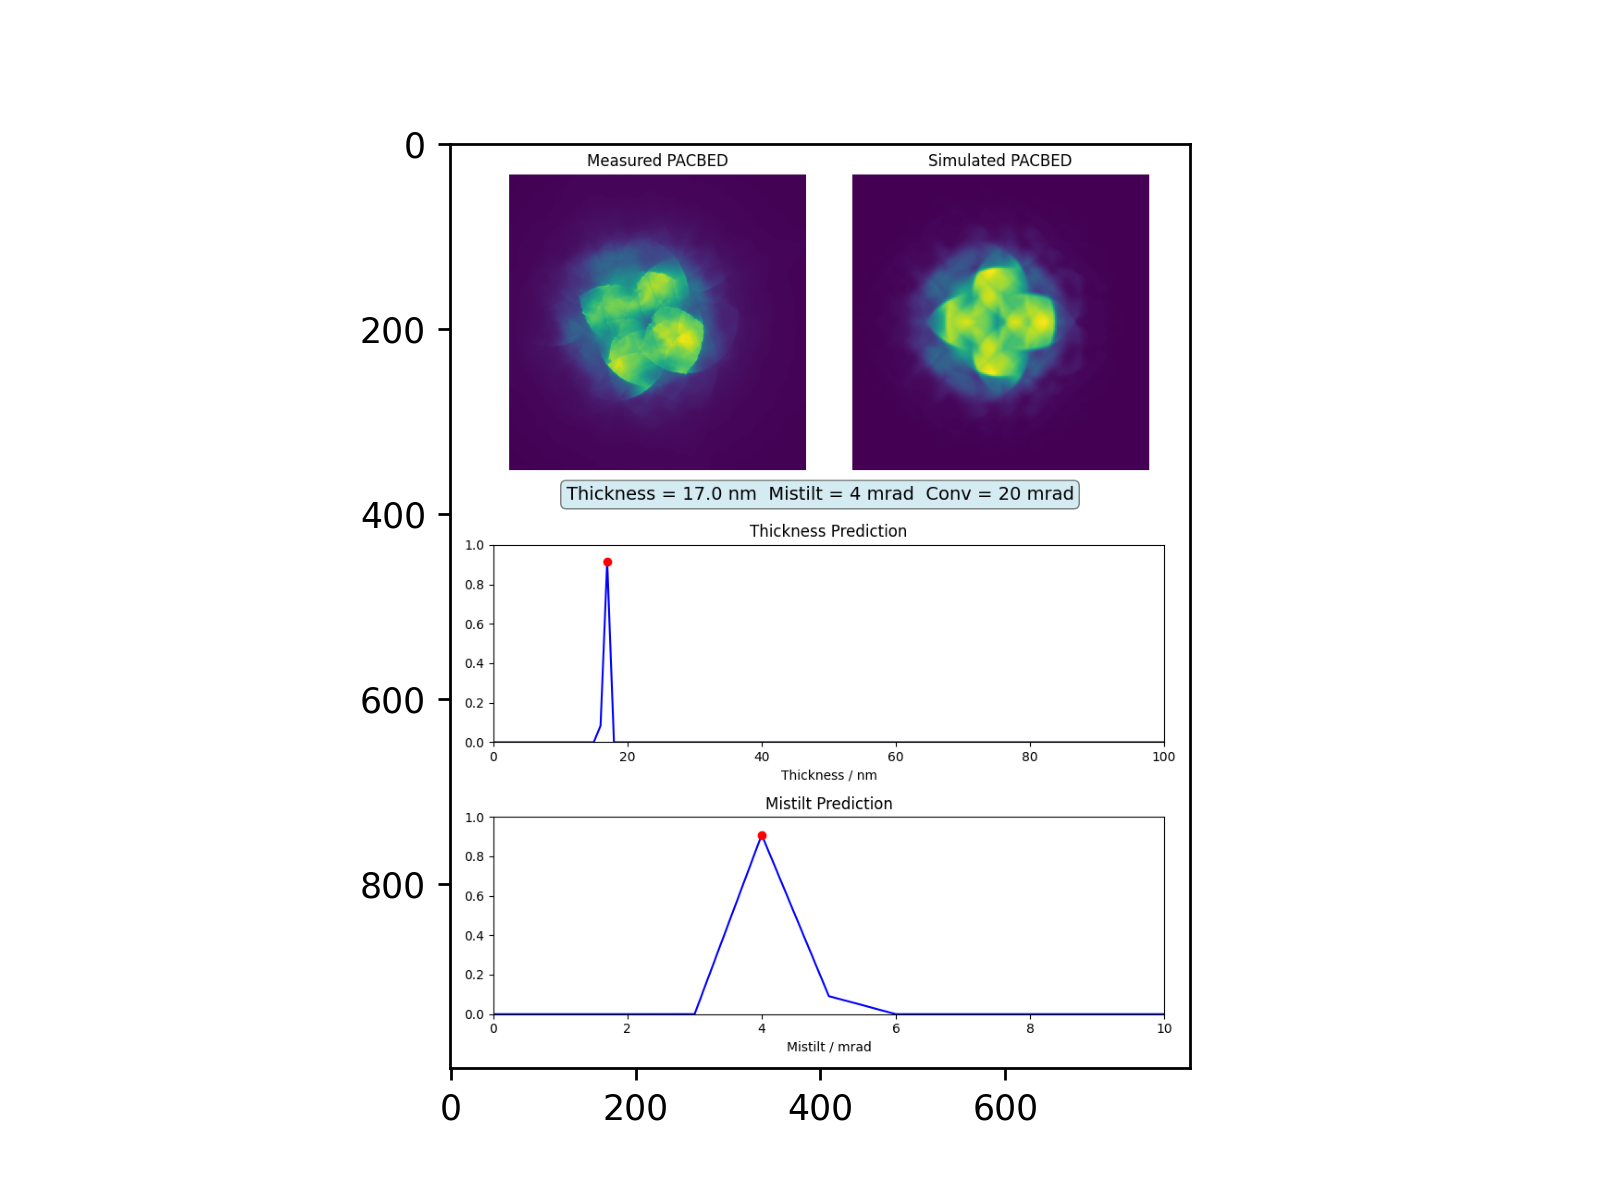

In [7]:
fig, axes = plt.subplots()
axes.imshow(result['validation'])

## Query with wrong crystal structure

This causes a visible mismatch in the validation image and a reduced confidence for the thickness.

In [8]:
%%time
result = query(
    image_array=pacbed['data'],
    crystal_structure='Strontium titanate',
    acceleration_voltage=80000,
    convergence_angle=20,
    zone_u=0, zone_v=0, zone_w=1,
    host='localhost',
    port='8230'
)

CPU times: user 53.4 ms, sys: 17.5 ms, total: 70.9 ms
Wall time: 2.42 s


<IPython.core.display.Javascript object>


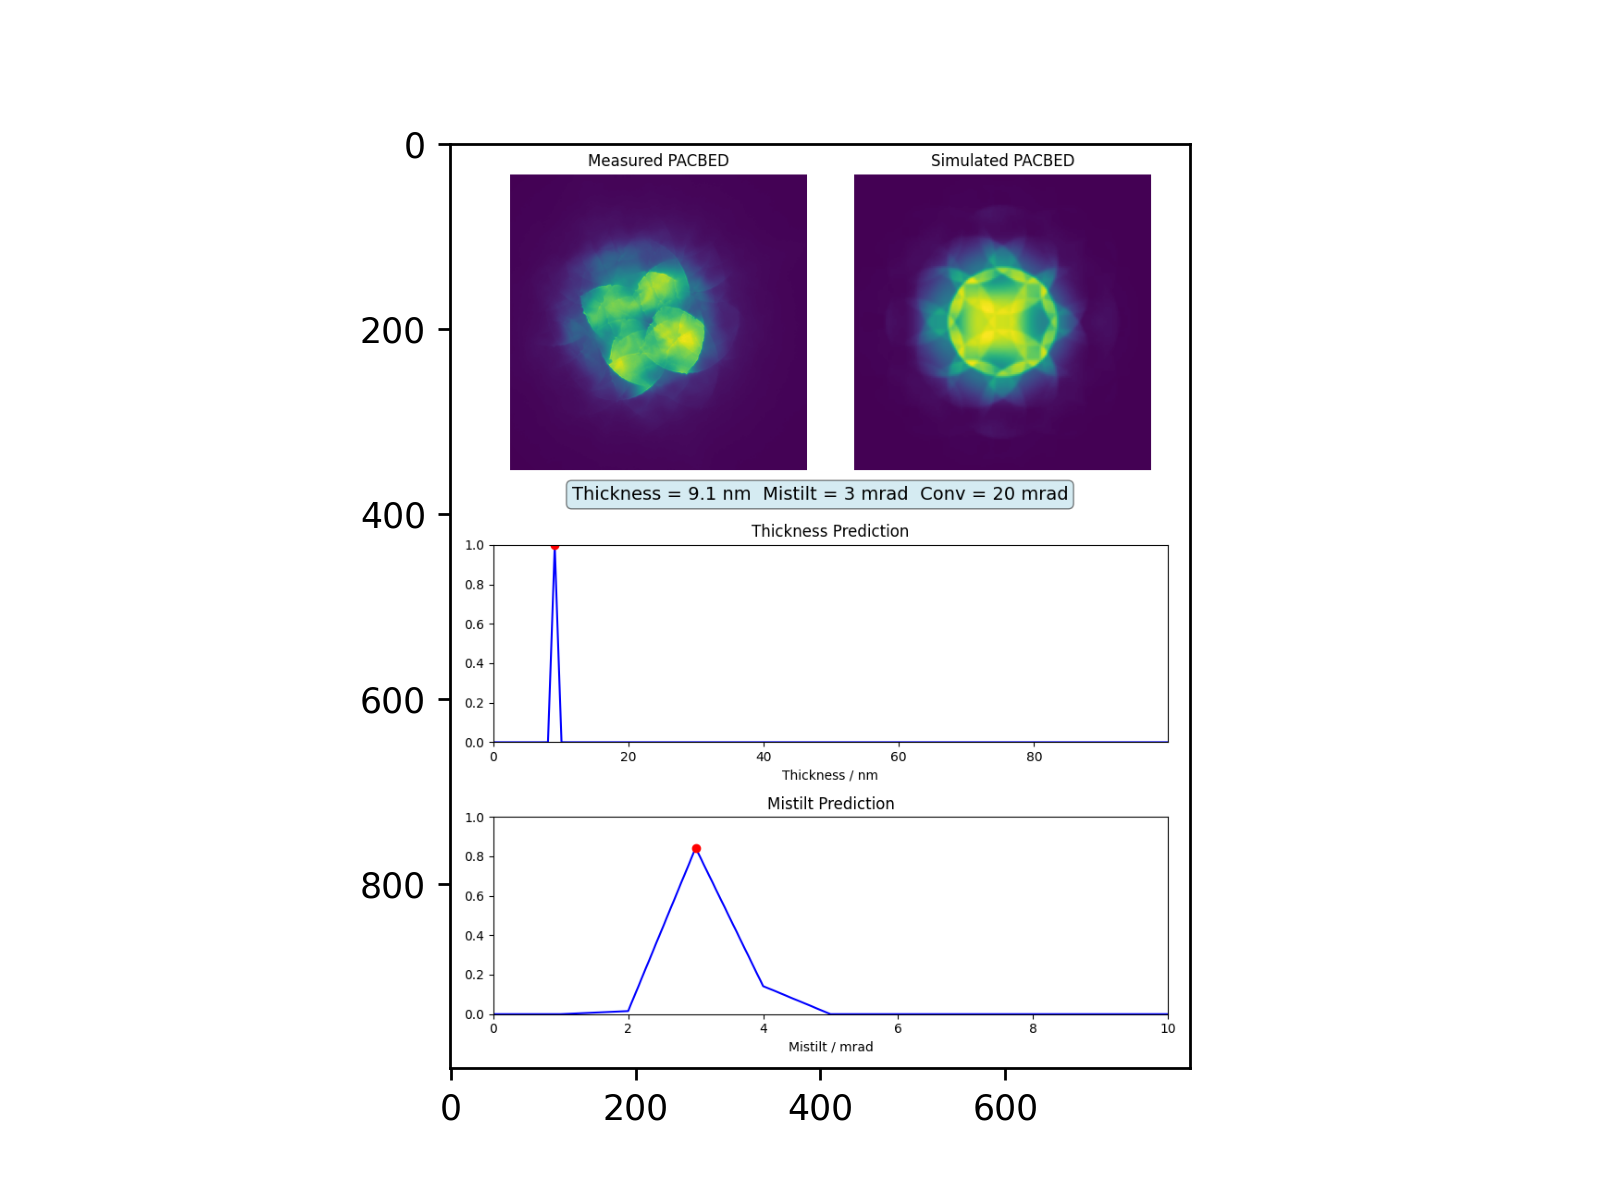

In [9]:
fig, axes = plt.subplots()
axes.imshow(result['validation'])

## Source code of the query function

This can serve as a template for implementation in other languages.

In [10]:
import inspect
from IPython.display import display, Code
display(Code(inspect.getsource(query), language='Python'))

def query(image_array: np.ndarray, crystal_structure: str, acceleration_voltage: int,
          convergence_angle: float, zone_u: int, zone_v: int, zone_w: int,
          host: str, port: int):
    '''
    Query the PACBED thickness and mistilt predictor service

    Parameters
    ----------

    image_array: numpy.ndarray
        Image data as NumPy array
    crystal_structure: str
        Identifier for the crystal structure. "Rutile" and "Strontium titanate"
        are supported in the current demo.
    acceleration_voltage: int
        Acceleration voltage in V. 80,000 and 300,000 are supported in the current demo.
    convergence_angle: float
        Convergence angle in mrad. 20 is supported in the current demo
    zone_u, zone_v, zone_w: int
        Zone axis. <0 0 1> is supported in the current demo.
    host: str
        Host of the web service
    port: int
        Port of the web service

    Returns
    -------
    dict
        Dictionary with the following keys:
        'thickness': float in Ångström
        'mistilt': float in mrad
        'scale': float, re-scaling of the PACBED pattern
        'validation': numpy.ndarray, RGB array with a validation plot
    '''
    resp = requests.post(f"http://{host}:{port}/inference/", files={
        "file": ("pacbed.raw", bytes(image_array), "application/octet-stream"),
        "parameters": (None, json.dumps({
            "file_params": {
                "typ": "raw",
                "dtype": str(image_array.dtype),
                "width": image_array.shape[1],
                "height": image_array.shape[0],
            },
            "physical_params": {
                "acceleration_voltage": acceleration_voltage,
                "zone_axis": {"u": zone_u, "v": zone_v, "w": zone_w},
                "crystal_structure": crystal_structure,
                "convergence_angle": convergence_angle,
            }
        }), "application/json"),
    }, )
    resp = resp.json()
    png_bytes = base64.b64decode(resp['validation'])
    bytes_io = io.BytesIO(png_bytes)

    pil_image = PIL.Image.open(bytes_io, formats=['PNG'])

    rgb = np.asarray(pil_image)
    resp['validation'] = rgb
    return resp